In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [8]:
df = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [12]:
df.head(50)

,Perimeter,Nature,Dated,Hours,Consumption,Forecast D-1,Forecast J,Fuel oil,Coal,Gas,...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,France,Données définitives,2017-01-01,00:00,76259.0,76100.0,76500.0,164.0,1579.0,7617.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,France,Données définitives,2017-01-01,00:15,NaN,75500.0,75800.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,France,Données définitives,2017-01-01,00:30,74981.0,74900.0,75100.0,601.0,1506.0,6626.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,France,Données définitives,2017-01-01,00:45,NaN,74150.0,74250.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,France,Données définitives,2017-01-01,01:00,72912.0,73400.0,73400.0,596.0,1291.0,6593.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,France,Données définitives,2017-01-01,01:15,NaN,73650.0,73650.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,France,Données définitives,2017-01-01,01:30,72682.0,73900.0,73900.0,587.0,1028.0,6595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,France,Données définitives,2017-01-01,01:45,NaN,73600.0,73600.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,France,Données définitives,2017-01-01,02:00,72166.0,73300.0,73300.0,599.0,1024.0,6548.0,...,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
9,France,Données définitives,2017-01-01,02:15,NaN,72350.0,72550.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df[['datetime','Wind','Consumption','Forecast D-1','Forecast J']].tail(20000)

,datetime,Wind,Consumption,Forecast D-1,Forecast J
104224,2019-12-22 14:00:00,9927.0,53756.0,52400.0,53000.0
104225,2019-12-22 14:15:00,NaN,NaN,52550.0,53050.0
104226,2019-12-22 14:30:00,9705.0,53733.0,52700.0,53100.0
104227,2019-12-22 14:45:00,NaN,NaN,53450.0,53650.0
104228,2019-12-22 15:00:00,9879.0,54593.0,54200.0,54200.0
...,...,...,...,...,...
124219,2020-07-17 20:45:00,NaN,NaN,ND,-
124220,2020-07-17 21:00:00,NaN,NaN,ND,-
124221,2020-07-17 21:15:00,NaN,NaN,ND,-
124222,2020-07-17 21:30:00,NaN,NaN,ND,-


In [68]:
df.columns

Index(['Perimeter', 'Nature', 'Dated', 'Hours', 'Consumption', 'Forecast D-1',
       'Forecast J', 'Fuel oil', 'Coal', 'Gas', 'Nuclear', 'Wind', 'Solar',
       'Hydraulic', 'Pumping', 'Bioenergies', 'Ech. physical', 'Co2 rate',
       'Ech. comm. England', 'Ech. comm. Spain', 'Ech. comm. Italy',
       'Ech. comm. Swiss', 'Ech. comm. Germany-Belgium', 'Fuel oil - TAC',
       'Fuel oil - Cogen.', 'Fuel oil - Others', 'Gas - TAC', 'Gas - Cogen.',
       'Gas - CCG', 'Gas - Others', 'Hydraulic - Stream of water + lock',
       'Hydraulics - Lakes', 'Hydraulics - STEP turbines',
       'Bioenergies - Waste', 'Bioenergies - Biomass', 'Bioenergies - Biogas',
       'datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N

In [76]:
df.head(500)[['datetime','Wind','guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)']]

,datetime,Wind,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N)
0,2016-12-31 22:00:00,267.0,NaN,NaN
1,2016-12-31 22:15:00,NaN,NaN,NaN
2,2016-12-31 22:30:00,311.0,NaN,NaN
3,2016-12-31 22:45:00,NaN,NaN,NaN
4,2016-12-31 23:00:00,351.0,NaN,NaN
5,2016-12-31 23:15:00,NaN,NaN,NaN
6,2016-12-31 23:30:00,367.0,NaN,NaN
7,2016-12-31 23:45:00,NaN,NaN,NaN
8,2017-01-01 00:00:00,360.0,1.86,212.0
9,2017-01-01 00:15:00,NaN,NaN,NaN


In [75]:
df[df['guitrancourt_Speed(m/s)'].notnull()].head(500)[['datetime','Wind','guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)']]

,datetime,Wind,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N)
8,2017-01-01 00:00:00,360.0,1.86,212.0
32,2017-01-01 06:00:00,527.0,2.47,194.0
56,2017-01-01 12:00:00,732.0,3.75,186.0
80,2017-01-01 18:00:00,830.0,3.22,192.0
104,2017-01-02 00:00:00,487.0,2.27,194.0
128,2017-01-02 06:00:00,371.0,0.59,332.0
152,2017-01-02 12:00:00,385.0,3.99,46.0
176,2017-01-02 18:00:00,1343.0,2.02,30.0
200,2017-01-03 00:00:00,1127.0,1.15,25.0
224,2017-01-03 06:00:00,1101.0,0.08,19.0


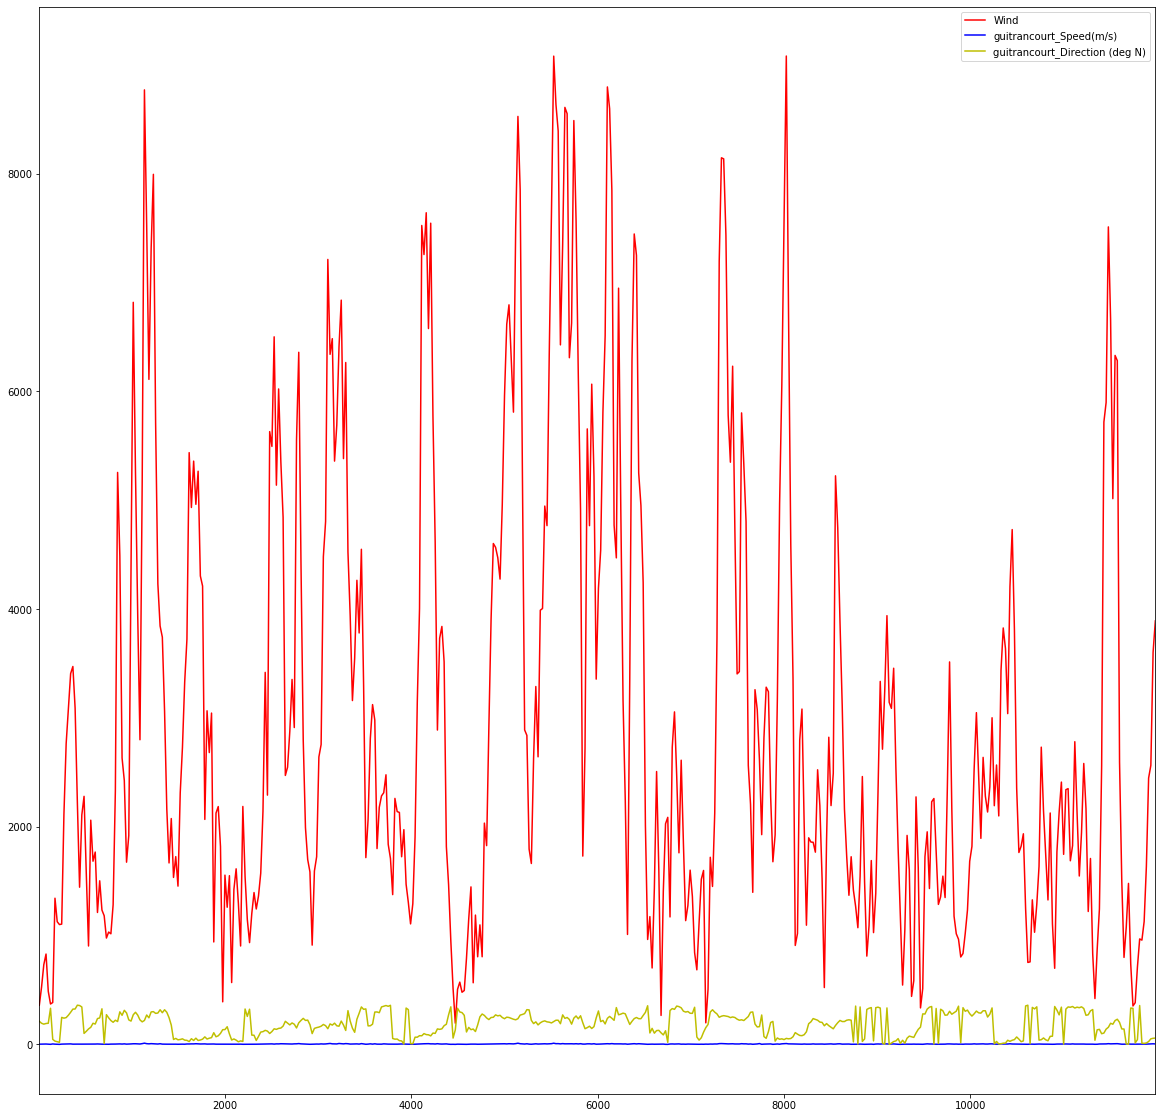

In [73]:
df[df['guitrancourt_Speed(m/s)'].notnull()].head(500)[['Wind','guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)']].astype(float).plot(style=['r','b','y'],figsize=(20,20))

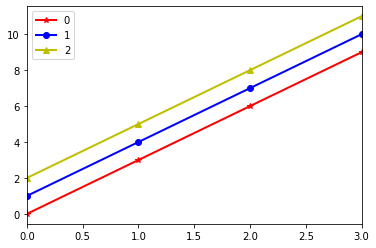

In [44]:
testdataframe=pd.DataFrame(np.arange(12).reshape(4,3))
testdataframe.plot(style=['r*-','bo-','y^-'], linewidth=2.0)

In [45]:
testdataframe

,0,1,2
0,0,1,2
1,3,4,5
2,6,7,8
3,9,10,11


In [19]:
df.columns

Index(['Perimeter', 'Nature', 'Dated', 'Hours', 'Consumption', 'Forecast D-1',
       'Forecast J', 'Fuel oil', 'Coal', 'Gas', 'Nuclear', 'Wind', 'Solar',
       'Hydraulic', 'Pumping', 'Bioenergies', 'Ech. physical', 'Co2 rate',
       'Ech. comm. England', 'Ech. comm. Spain', 'Ech. comm. Italy',
       'Ech. comm. Swiss', 'Ech. comm. Germany-Belgium', 'Fuel oil - TAC',
       'Fuel oil - Cogen.', 'Fuel oil - Others', 'Gas - TAC', 'Gas - Cogen.',
       'Gas - CCG', 'Gas - Others', 'Hydraulic - Stream of water + lock',
       'Hydraulics - Lakes', 'Hydraulics - STEP turbines',
       'Bioenergies - Waste', 'Bioenergies - Biomass', 'Bioenergies - Biogas',
       'datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N

In [11]:
df[df['angerville-2-b_Direction (deg N)'].notnull()].head(50)

,Perimeter,Nature,Dated,Hours,Consumption,Forecast D-1,Forecast J,Fuel oil,Coal,Gas,...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
8,France,Données définitives,2017-01-01,02:00,72166.0,73300.0,73300.0,599.0,1024.0,6548.0,...,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
32,France,Données définitives,2017-01-01,08:00,64178.0,66300.0,64900.0,175.0,1007.0,5641.0,...,2.48,203.0,2.50,203.0,2.69,201.0,2.62,201.0,2.62,201.0
56,France,Données définitives,2017-01-01,14:00,69027.0,67800.0,69700.0,193.0,1047.0,5692.0,...,4.41,228.0,4.41,227.0,4.36,219.0,4.31,219.0,4.31,219.0
80,France,Données définitives,2017-01-01,20:00,73881.0,73300.0,74200.0,608.0,1098.0,6555.0,...,2.82,201.0,2.87,200.0,3.21,197.0,3.20,195.0,3.20,195.0
104,France,Données définitives,2017-01-02,02:00,65635.0,68200.0,66900.0,472.0,839.0,6317.0,...,2.80,210.0,2.84,209.0,3.28,203.0,3.21,201.0,3.22,201.0
128,France,Données définitives,2017-01-02,08:00,73021.0,77000.0,74000.0,565.0,2187.0,7277.0,...,0.48,213.0,0.49,212.0,0.21,265.0,0.17,311.0,0.17,311.0
152,France,Données définitives,2017-01-02,14:00,78169.0,80400.0,78500.0,579.0,2193.0,8040.0,...,1.05,28.0,1.13,26.0,2.25,21.0,2.31,20.0,2.31,20.0
176,France,Données définitives,2017-01-02,20:00,80850.0,82800.0,80500.0,601.0,2019.0,8422.0,...,3.54,36.0,3.54,36.0,3.72,36.0,3.84,37.0,3.84,37.0
200,France,Données définitives,2017-01-03,02:00,70052.0,72700.0,71200.0,646.0,1919.0,7619.0,...,3.12,46.0,3.06,45.0,2.85,42.0,3.05,45.0,3.04,45.0
224,France,Données définitives,2017-01-03,08:00,82934.0,85600.0,83500.0,933.0,2318.0,8663.0,...,1.92,58.0,1.88,57.0,1.51,52.0,1.63,53.0,1.62,53.0
